# 1 Support Vector Machines

In the first half of this exercise, you will be using support vector machines (SVMs) with various example 2D datasets. Experimenting with these datasets will help you gain an intuition of how SVMs work and how to use a Gaussian kernel with SVMs. In the next half of the exercise, you will be using support vector machines to build a spam classifier.

The provided script, `ex6.m`, will help you step through the first half of the exercise.

## 1.1 Example Dataset 1

We will begin by with a 2D example dataset which can be separated by a linear boundary. The script `ex6.m` will plot the training data (Figure 1). In this dataset, the positions of the positive examples (indicated with +) and the negative examples (indicated with o) suggest a natural separation indicated by the gap. However, notice that there is an outlier positive example + on the far left at about (0.1, 4.1). As part of this exercise, you will also see how this outlier affects the SVM decision boundary.


Loading and Visualizing Data ...


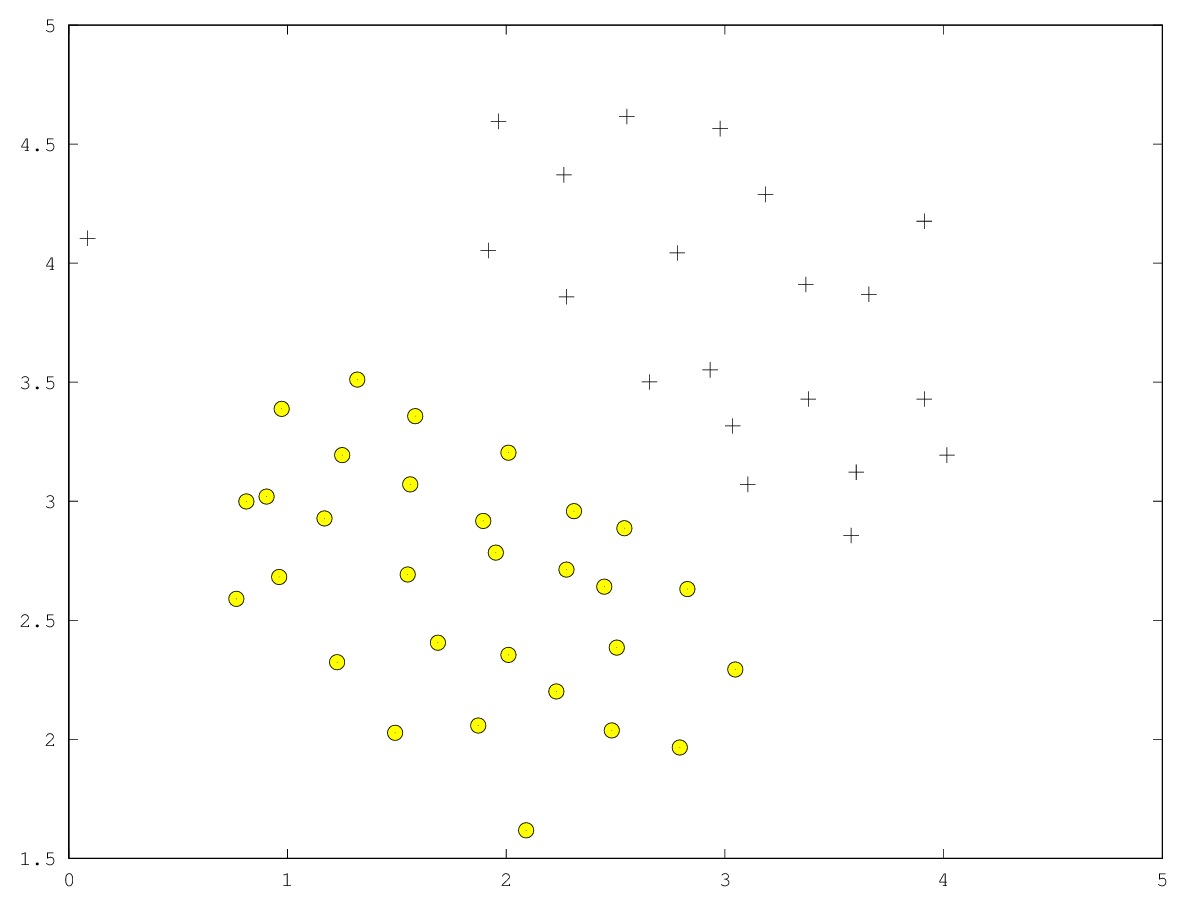

In [7]:
clear; close all; clc

function plotData(X, y)
    %PLOTDATA Plots the data points X and y into a new figure 
    %   PLOTDATA(x,y) plots the data points with + for the positive examples
    %   and o for the negative examples. X is assumed to be a Mx2 matrix.
    %
    % Note: This was slightly modified such that it expects y = 1 or y = 0

    % Find Indices of Positive and Negative Examples
    pos = find(y == 1); neg = find(y == 0);

    % Plot Examples
    plot(X(pos, 1), X(pos, 2), 'k+','LineWidth', 1, 'MarkerSize', 7)
    hold on;
    plot(X(neg, 1), X(neg, 2), 'ko', 'MarkerFaceColor', 'y', 'MarkerSize', 7)
    hold off;
end

fprintf('Loading and Visualizing Data ...\n')
load('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 7/Assignment/ex6/ex6data1.mat');
plotData(X, y);

In this part of the exercise, you will try using different values of the C parameter with SVMs. Informally, the C parameter is a positive value that controls the penalty for misclassified training examples. A large C parameter tells the SVM to try to classify all the examples correctly. C plays a role similar to $\frac{\lambda}{1}$ , where $\lambda$ is the regularization parameter that we were using previously for logistic regression.

The next part in `ex6.m` will run the SVM training (with C=1) using SVM software that we have included with the starter code, `svmTrain.m`. When C=1, you should find that the SVM puts the decision boundary in the gap between the two datasets and misclassifies the data point on the far left (Figure 2).

**Implementation Note:** Most SVM software packages (including `svmTrain.m`) automatically add the extra feature $x_0 = 1$ for you and automatically take care of learning the intercept term $\theta_0$ . So when passing your training data to the SVM software, there is no need to add this extra feature $x_0 = 1$ yourself. In particular, in Octave/MATLAB your code should be working with training examples $x \in \mathbb{R}^n$ (rather than $x \in \mathbb{R}^{n+1}$); for example, in the first example dataset $x \in \mathbb{R}^2$.

Your task is to try different values of C on this dataset. Specifically, you should change the value of C in the script to C=100 and run the SVM training again. When C=100, you should find that the SVM now classifies every single example correctly, but has a decision boundary that does not appear to be a natural fit for the data (Figure 3).

In [1]:
function [model] = svmTrain(X, Y, C, kernelFunction, tol, max_passes)
    %SVMTRAIN Trains an SVM classifier using a simplified version of the SMO 
    %algorithm. 
    %   [model] = SVMTRAIN(X, Y, C, kernelFunction, tol, max_passes) trains an
    %   SVM classifier and returns trained model. X is the matrix of training 
    %   examples.  Each row is a training example, and the jth column holds the 
    %   jth feature.  Y is a column matrix containing 1 for positive examples 
    %   and 0 for negative examples.  C is the standard SVM regularization 
    %   parameter.  tol is a tolerance value used for determining equality of 
    %   floating point numbers. max_passes controls the number of iterations
    %   over the dataset (without changes to alpha) before the algorithm quits.
    %
    % Note: This is a simplified version of the SMO algorithm for training
    %       SVMs. In practice, if you want to train an SVM classifier, we
    %       recommend using an optimized package such as:  
    %
    %           LIBSVM   (http://www.csie.ntu.edu.tw/~cjlin/libsvm/)
    %           SVMLight (http://svmlight.joachims.org/)
    %
    %

    if ~exist('tol', 'var') || isempty(tol)
        tol = 1e-3;
    end

    if ~exist('max_passes', 'var') || isempty(max_passes)
        max_passes = 5;
    end

    % Data parameters
    m = size(X, 1);
    n = size(X, 2);

    % Map 0 to -1
    Y(Y==0) = -1;

    % Variables
    alphas = zeros(m, 1);
    b = 0;
    E = zeros(m, 1);
    passes = 0;
    eta = 0;
    L = 0;
    H = 0;

    % Pre-compute the Kernel Matrix since our dataset is small
    % (in practice, optimized SVM packages that handle large datasets
    %  gracefully will _not_ do this)
    % 
    % We have implemented optimized vectorized version of the Kernels here so
    % that the svm training will run faster.
    if strcmp(func2str(kernelFunction), 'linearKernel')
        % Vectorized computation for the Linear Kernel
        % This is equivalent to computing the kernel on every pair of examples
        K = X*X';
    elseif strfind(func2str(kernelFunction), 'gaussianKernel')
        % Vectorized RBF Kernel
        % This is equivalent to computing the kernel on every pair of examples
        X2 = sum(X.^2, 2);
        K = bsxfun(@plus, X2, bsxfun(@plus, X2', - 2 * (X * X')));
        K = kernelFunction(1, 0) .^ K;
    else
        % Pre-compute the Kernel Matrix
        % The following can be slow due to the lack of vectorization
        K = zeros(m);
        for i = 1:m
            for j = i:m
                 K(i,j) = kernelFunction(X(i,:)', X(j,:)');
                 K(j,i) = K(i,j); %the matrix is symmetric
            end
        end
    end

    % Train
    fprintf('\nTraining ...');
    dots = 12;
    while passes < max_passes,

        num_changed_alphas = 0;
        for i = 1:m,

            % Calculate Ei = f(x(i)) - y(i) using (2). 
            % E(i) = b + sum (X(i, :) * (repmat(alphas.*Y,1,n).*X)') - Y(i);
            E(i) = b + sum (alphas.*Y.*K(:,i)) - Y(i);

            if ((Y(i)*E(i) < -tol && alphas(i) < C) || (Y(i)*E(i) > tol && alphas(i) > 0)),

                % In practice, there are many heuristics one can use to select
                % the i and j. In this simplified code, we select them randomly.
                j = ceil(m * rand());
                while j == i,  % Make sure i \neq j
                    j = ceil(m * rand());
                end

                % Calculate Ej = f(x(j)) - y(j) using (2).
                E(j) = b + sum (alphas.*Y.*K(:,j)) - Y(j);

                % Save old alphas
                alpha_i_old = alphas(i);
                alpha_j_old = alphas(j);

                % Compute L and H by (10) or (11). 
                if (Y(i) == Y(j)),
                    L = max(0, alphas(j) + alphas(i) - C);
                    H = min(C, alphas(j) + alphas(i));
                else
                    L = max(0, alphas(j) - alphas(i));
                    H = min(C, C + alphas(j) - alphas(i));
                end

                if (L == H),
                    % continue to next i. 
                    continue;
                end

                % Compute eta by (14).
                eta = 2 * K(i,j) - K(i,i) - K(j,j);
                if (eta >= 0),
                    % continue to next i. 
                    continue;
                end

                % Compute and clip new value for alpha j using (12) and (15).
                alphas(j) = alphas(j) - (Y(j) * (E(i) - E(j))) / eta;

                % Clip
                alphas(j) = min (H, alphas(j));
                alphas(j) = max (L, alphas(j));

                % Check if change in alpha is significant
                if (abs(alphas(j) - alpha_j_old) < tol),
                    % continue to next i. 
                    % replace anyway
                    alphas(j) = alpha_j_old;
                    continue;
                end

                % Determine value for alpha i using (16). 
                alphas(i) = alphas(i) + Y(i)*Y(j)*(alpha_j_old - alphas(j));

                % Compute b1 and b2 using (17) and (18) respectively. 
                b1 = b - E(i) ...
                     - Y(i) * (alphas(i) - alpha_i_old) *  K(i,j)' ...
                     - Y(j) * (alphas(j) - alpha_j_old) *  K(i,j)';
                b2 = b - E(j) ...
                     - Y(i) * (alphas(i) - alpha_i_old) *  K(i,j)' ...
                     - Y(j) * (alphas(j) - alpha_j_old) *  K(j,j)';

                % Compute b by (19). 
                if (0 < alphas(i) && alphas(i) < C),
                    b = b1;
                elseif (0 < alphas(j) && alphas(j) < C),
                    b = b2;
                else
                    b = (b1+b2)/2;
                end

                num_changed_alphas = num_changed_alphas + 1;

            end

        end

        if (num_changed_alphas == 0),
            passes = passes + 1;
        else
            passes = 0;
        end

        fprintf('.');
        dots = dots + 1;
        if dots > 78
            dots = 0;
            fprintf('\n');
        end
        if exist('OCTAVE_VERSION')
            fflush(stdout);
        end
    end
    fprintf(' Done! \n\n');

    % Save the model
    idx = alphas > 0;
    model.X= X(idx,:);
    model.y= Y(idx);
    model.kernelFunction = kernelFunction;
    model.b= b;
    model.alphas= alphas(idx);
    model.w = ((alphas.*Y)'*X)';
end

In [2]:
function sim = linearKernel(x1, x2)
    %LINEARKERNEL returns a linear kernel between x1 and x2
    %   sim = linearKernel(x1, x2) returns a linear kernel between x1 and x2
    %   and returns the value in sim

    % Ensure that x1 and x2 are column vectors
    x1 = x1(:); x2 = x2(:);

    % Compute the kernel
    sim = x1' * x2;  % dot product
end

In [3]:
function visualizeBoundaryLinear(X, y, model)
    %VISUALIZEBOUNDARYLINEAR plots a linear decision boundary learned by the
    %SVM
    %   VISUALIZEBOUNDARYLINEAR(X, y, model) plots a linear decision boundary 
    %   learned by the SVM and overlays the data on it

    w = model.w;
    b = model.b;
    xp = linspace(min(X(:,1)), max(X(:,1)), 100);
    yp = - (w(1)*xp + b)/w(2);
    plotData(X, y);
    hold on;
    plot(xp, yp, '-b'); 
    hold off
end


Training Linear SVM ...

Training ......................................................................
 Done! 



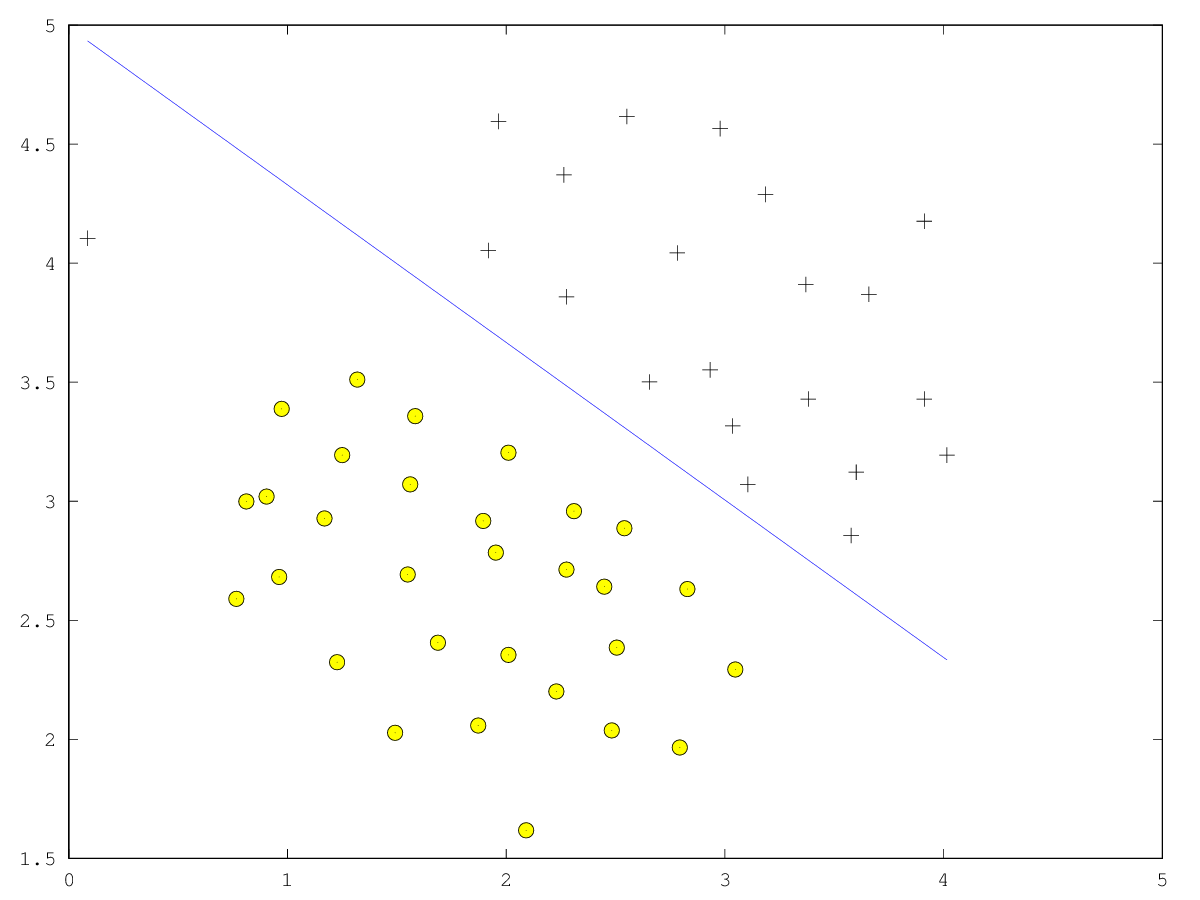

In [6]:
load('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 7/Assignment/ex6/ex6data1.mat');
fprintf('\nTraining Linear SVM ...\n')

% You should try to change the C value below and see how the decision
% boundary varies (e.g., try C = 1000)
C = 1;
model = svmTrain(X, y, C, @linearKernel, 1e-3, 20);
visualizeBoundaryLinear(X, y, model);


Training Linear SVM ...

Training ......................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
..............

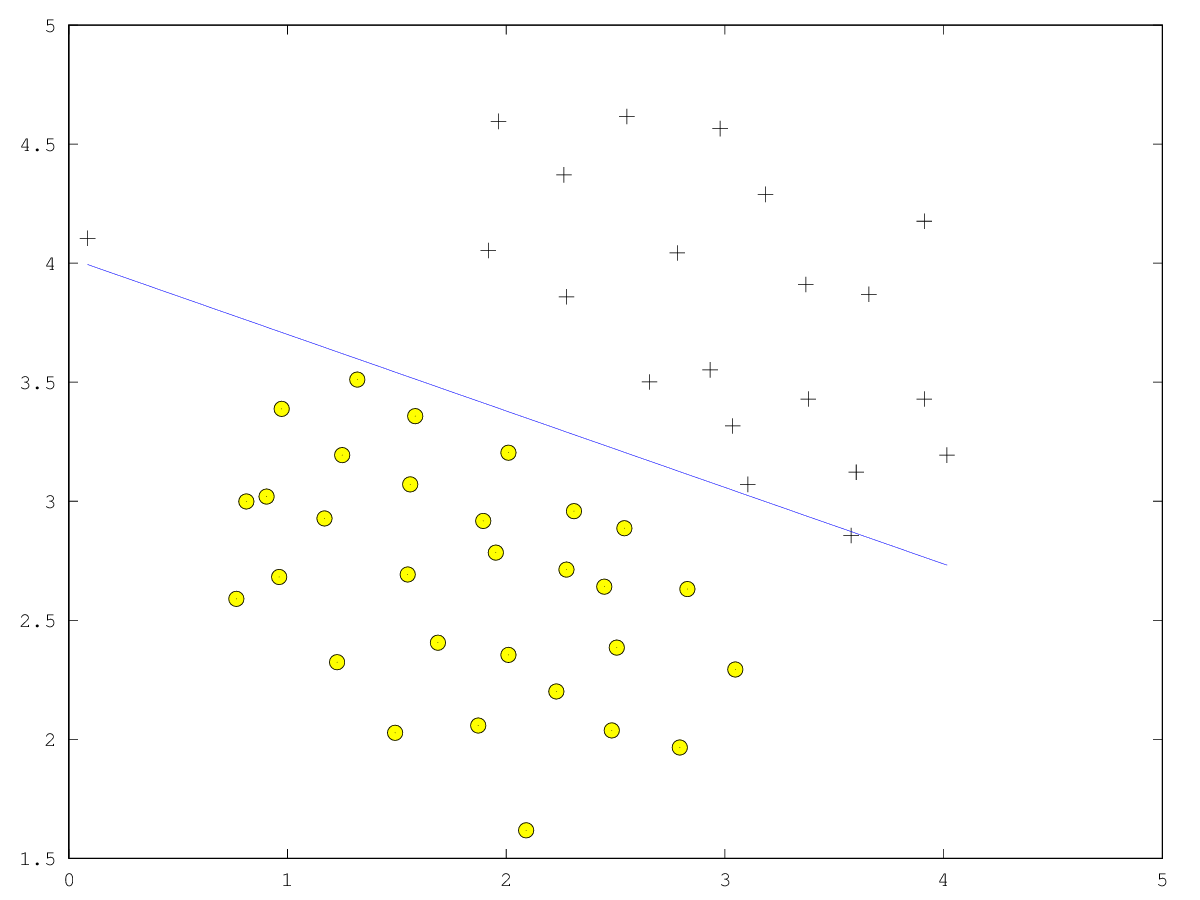

In [7]:
load('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 7/Assignment/ex6/ex6data1.mat');
fprintf('\nTraining Linear SVM ...\n')

% You should try to change the C value below and see how the decision
% boundary varies (e.g., try C = 1000)
C = 100;
model = svmTrain(X, y, C, @linearKernel, 1e-3, 20);
visualizeBoundaryLinear(X, y, model);

## 1.2 SVM with Gaussian Kernels

In this part of the exercise, you will be using SVMs to do non-linear classification. In particular, you will be using SVMs with Gaussian kernels on datasets that are not linearly separable.


### 1.2.1 Gaussian Kernel

To find non-linear decision boundaries with the SVM, we need to first implement a Gaussian kernel. You can think of the Gaussian kernel as a similarity function that measures the "distance" between a pair of examples, ($x^{(i)}, x^{(j)}$). The Gaussian kernel is also parameterized by a bandwidth parameter, $\sigma$, which determines how fast the similarity metric decreases (to 0) as the examples are further apart. 

You should now complete the code in `gaussianKernel.m` to compute the Gaussian kernel between two examples, ($x^{(i)}, x^{(j)}$). The Gaussian kernel function is defined as:

$$K_{gaussian}(x^{(i)}, x^{(j)}) = exp \left( - \frac{||x^{(i)} - x^{(j)}||^2}{2\sigma^2} \right) = exp \left( - \frac{\sum_{k=1}^n (x_k^{(i)} - x_k^{(j)})^2}{2\sigma^2} \right)$$

Once you've completed the function `gaussianKernel.m`, the script `ex6.m` will test your kernel function on two provided examples and you should expect to see a value of 0.324652.

In [4]:
% gaussianKernel.m
function sim = gaussianKernel(x1, x2, sigma)
    %RBFKERNEL returns a radial basis function kernel between x1 and x2
    %   sim = gaussianKernel(x1, x2) returns a gaussian kernel between x1 and x2
    %   and returns the value in sim

    % Ensure that x1 and x2 are column vectors
    x1 = x1(:); x2 = x2(:);

    % You need to return the following variables correctly.
    sim = 0;

    % ====================== YOUR CODE HERE ======================
    % Instructions: Fill in this function to return the similarity between x1
    %               and x2 computed using a Gaussian kernel with bandwidth
    %               sigma
    %
    %
    nominator = sum((x1-x2).^2);
    sim = e^(-nominator/(2*sigma^2));
    
end

In [5]:
% ex6.m
fprintf('\nEvaluating the Gaussian Kernel ...\n')

x1 = [1 2 1]; x2 = [0 4 -1]; sigma = 2;
sim = gaussianKernel(x1, x2, sigma);

fprintf(['Gaussian Kernel between x1 = [1; 2; 1], x2 = [0; 4; -1], sigma = 0.5 :' ...
         '\n\t%f\n(this value should be about 0.324652)\n'], sim);


Evaluating the Gaussian Kernel ...
Gaussian Kernel between x1 = [1; 2; 1], x2 = [0; 4; -1], sigma = 0.5 :
	0.324652
(this value should be about 0.324652)


### 1.2.2 Example Dataset 2

The next part in `ex6.m` will load and plot dataset 2 (Figure 4). From the figure, you can obserse that there is no linear decision boundary that separates the positive and negative examples for this dataset. However, by using the Gaussian kernel with the SVM, you will be able to learn a non-linear decision boundary that can perform reasonably well for the dataset.

Loading and Visualizing Data ...


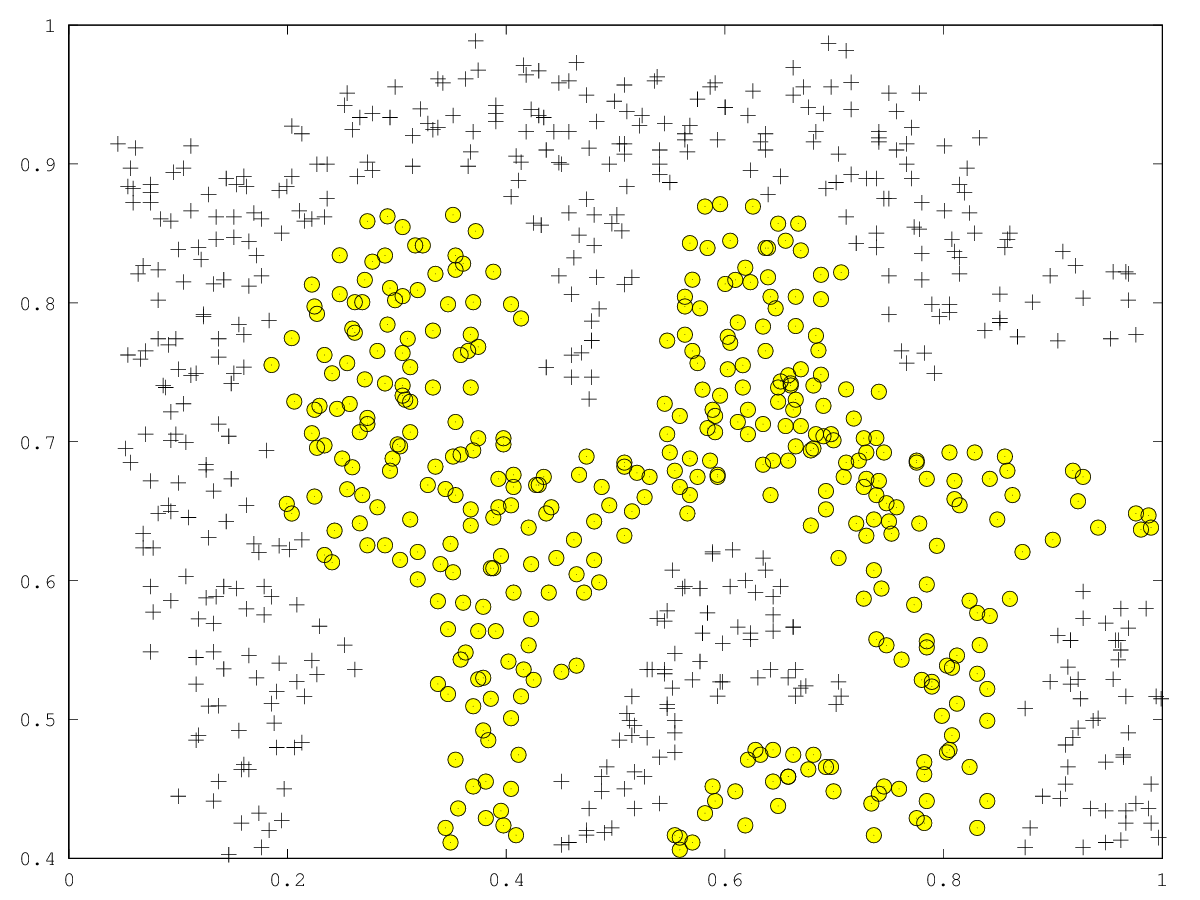

In [8]:
fprintf('Loading and Visualizing Data ...\n')

% Load from ex6data2: 
% You will have X, y in your environment
load('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 7/Assignment/ex6/ex6data2.mat');

% Plot training data
plotData(X, y);

If you have correctly implemented the Gaussian kernel function, `ex6.m` will proceed to train the SVM with the Gaussian kernel on this dataset. Figure 5 shows the decision boundary found by the SVM with a Gaussian kernel. The decision boundary is able to separate most of the positive and negative examples correctly and follows the contours of the dataset well.

In [9]:
function [model] = svmTrain(X, Y, C, kernelFunction, tol, max_passes)
    %SVMTRAIN Trains an SVM classifier using a simplified version of the SMO 
    %algorithm. 
    %   [model] = SVMTRAIN(X, Y, C, kernelFunction, tol, max_passes) trains an
    %   SVM classifier and returns trained model. X is the matrix of training 
    %   examples.  Each row is a training example, and the jth column holds the 
    %   jth feature.  Y is a column matrix containing 1 for positive examples 
    %   and 0 for negative examples.  C is the standard SVM regularization 
    %   parameter.  tol is a tolerance value used for determining equality of 
    %   floating point numbers. max_passes controls the number of iterations
    %   over the dataset (without changes to alpha) before the algorithm quits.
    %
    % Note: This is a simplified version of the SMO algorithm for training
    %       SVMs. In practice, if you want to train an SVM classifier, we
    %       recommend using an optimized package such as:  
    %
    %           LIBSVM   (http://www.csie.ntu.edu.tw/~cjlin/libsvm/)
    %           SVMLight (http://svmlight.joachims.org/)
    %
    %

    if ~exist('tol', 'var') || isempty(tol)
        tol = 1e-3;
    end

    if ~exist('max_passes', 'var') || isempty(max_passes)
        max_passes = 5;
    end

    % Data parameters
    m = size(X, 1);
    n = size(X, 2);

    % Map 0 to -1
    Y(Y==0) = -1;

    % Variables
    alphas = zeros(m, 1);
    b = 0;
    E = zeros(m, 1);
    passes = 0;
    eta = 0;
    L = 0;
    H = 0;

    % Pre-compute the Kernel Matrix since our dataset is small
    % (in practice, optimized SVM packages that handle large datasets
    %  gracefully will _not_ do this)
    % 
    % We have implemented optimized vectorized version of the Kernels here so
    % that the svm training will run faster.
    if strcmp(func2str(kernelFunction), 'linearKernel')
        % Vectorized computation for the Linear Kernel
        % This is equivalent to computing the kernel on every pair of examples
        K = X*X';
    elseif strfind(func2str(kernelFunction), 'gaussianKernel')
        % Vectorized RBF Kernel
        % This is equivalent to computing the kernel on every pair of examples
        X2 = sum(X.^2, 2);
        K = bsxfun(@plus, X2, bsxfun(@plus, X2', - 2 * (X * X')));
        K = kernelFunction(1, 0) .^ K;
    else
        % Pre-compute the Kernel Matrix
        % The following can be slow due to the lack of vectorization
        K = zeros(m);
        for i = 1:m
            for j = i:m
                 K(i,j) = kernelFunction(X(i,:)', X(j,:)');
                 K(j,i) = K(i,j); %the matrix is symmetric
            end
        end
    end

    % Train
    fprintf('\nTraining ...');
    dots = 12;
    while passes < max_passes,

        num_changed_alphas = 0;
        for i = 1:m,

            % Calculate Ei = f(x(i)) - y(i) using (2). 
            % E(i) = b + sum (X(i, :) * (repmat(alphas.*Y,1,n).*X)') - Y(i);
            E(i) = b + sum (alphas.*Y.*K(:,i)) - Y(i);

            if ((Y(i)*E(i) < -tol && alphas(i) < C) || (Y(i)*E(i) > tol && alphas(i) > 0)),

                % In practice, there are many heuristics one can use to select
                % the i and j. In this simplified code, we select them randomly.
                j = ceil(m * rand());
                while j == i,  % Make sure i \neq j
                    j = ceil(m * rand());
                end

                % Calculate Ej = f(x(j)) - y(j) using (2).
                E(j) = b + sum (alphas.*Y.*K(:,j)) - Y(j);

                % Save old alphas
                alpha_i_old = alphas(i);
                alpha_j_old = alphas(j);

                % Compute L and H by (10) or (11). 
                if (Y(i) == Y(j)),
                    L = max(0, alphas(j) + alphas(i) - C);
                    H = min(C, alphas(j) + alphas(i));
                else
                    L = max(0, alphas(j) - alphas(i));
                    H = min(C, C + alphas(j) - alphas(i));
                end

                if (L == H),
                    % continue to next i. 
                    continue;
                end

                % Compute eta by (14).
                eta = 2 * K(i,j) - K(i,i) - K(j,j);
                if (eta >= 0),
                    % continue to next i. 
                    continue;
                end

                % Compute and clip new value for alpha j using (12) and (15).
                alphas(j) = alphas(j) - (Y(j) * (E(i) - E(j))) / eta;

                % Clip
                alphas(j) = min (H, alphas(j));
                alphas(j) = max (L, alphas(j));

                % Check if change in alpha is significant
                if (abs(alphas(j) - alpha_j_old) < tol),
                    % continue to next i. 
                    % replace anyway
                    alphas(j) = alpha_j_old;
                    continue;
                end

                % Determine value for alpha i using (16). 
                alphas(i) = alphas(i) + Y(i)*Y(j)*(alpha_j_old - alphas(j));

                % Compute b1 and b2 using (17) and (18) respectively. 
                b1 = b - E(i) ...
                     - Y(i) * (alphas(i) - alpha_i_old) *  K(i,j)' ...
                     - Y(j) * (alphas(j) - alpha_j_old) *  K(i,j)';
                b2 = b - E(j) ...
                     - Y(i) * (alphas(i) - alpha_i_old) *  K(i,j)' ...
                     - Y(j) * (alphas(j) - alpha_j_old) *  K(j,j)';

                % Compute b by (19). 
                if (0 < alphas(i) && alphas(i) < C),
                    b = b1;
                elseif (0 < alphas(j) && alphas(j) < C),
                    b = b2;
                else
                    b = (b1+b2)/2;
                end

                num_changed_alphas = num_changed_alphas + 1;

            end

        end

        if (num_changed_alphas == 0),
            passes = passes + 1;
        else
            passes = 0;
        end

        fprintf('.');
        dots = dots + 1;
        if dots > 78
            dots = 0;
            fprintf('\n');
        end
        if exist('OCTAVE_VERSION')
            fflush(stdout);
        end
    end
    fprintf(' Done! \n\n');

    % Save the model
    idx = alphas > 0;
    model.X= X(idx,:);
    model.y= Y(idx);
    model.kernelFunction = kernelFunction;
    model.b= b;
    model.alphas= alphas(idx);
    model.w = ((alphas.*Y)'*X)';

end

In [ ]:
function pred = svmPredict(model, X)
    %SVMPREDICT returns a vector of predictions using a trained SVM model
    %(svmTrain). 
    %   pred = SVMPREDICT(model, X) returns a vector of predictions using a 
    %   trained SVM model (svmTrain). X is a mxn matrix where there each 
    %   example is a row. model is a svm model returned from svmTrain.
    %   predictions pred is a m x 1 column of predictions of {0, 1} values.
    %

    % Check if we are getting a column vector, if so, then assume that we only
    % need to do prediction for a single example
    if (size(X, 2) == 1)
        % Examples should be in rows
        X = X';
    end

    % Dataset 
    m = size(X, 1);
    p = zeros(m, 1);
    pred = zeros(m, 1);

    if strcmp(func2str(model.kernelFunction), 'linearKernel')
        % We can use the weights and bias directly if working with the 
        % linear kernel
        p = X * model.w + model.b;
    elseif strfind(func2str(model.kernelFunction), 'gaussianKernel')
        % Vectorized RBF Kernel
        % This is equivalent to computing the kernel on every pair of examples
        X1 = sum(X.^2, 2);
        X2 = sum(model.X.^2, 2)';
        K = bsxfun(@plus, X1, bsxfun(@plus, X2, - 2 * X * model.X'));
        K = model.kernelFunction(1, 0) .^ K;
        K = bsxfun(@times, model.y', K);
        K = bsxfun(@times, model.alphas', K);
        p = sum(K, 2);
    else
        % Other Non-linear kernel
        for i = 1:m
            prediction = 0;
            for j = 1:size(model.X, 1)
                prediction = prediction + ...
                    model.alphas(j) * model.y(j) * ...
                    model.kernelFunction(X(i,:)', model.X(j,:)');
            end
            p(i) = prediction + model.b;
        end
    end

    % Convert predictions into 0 / 1
    pred(p >= 0) =  1;
    pred(p <  0) =  0;

end

In [13]:
function visualizeBoundary(X, y, model, varargin)
    %VISUALIZEBOUNDARY plots a non-linear decision boundary learned by the SVM
    %   VISUALIZEBOUNDARYLINEAR(X, y, model) plots a non-linear decision 
    %   boundary learned by the SVM and overlays the data on it

    % Plot the training data on top of the boundary
    plotData(X, y)

    % Make classification predictions over a grid of values
    x1plot = linspace(min(X(:,1)), max(X(:,1)), 100)';
    x2plot = linspace(min(X(:,2)), max(X(:,2)), 100)';
    [X1, X2] = meshgrid(x1plot, x2plot);
    vals = zeros(size(X1));
    for i = 1:size(X1, 2)
       this_X = [X1(:, i), X2(:, i)];
       vals(:, i) = svmPredict(model, this_X);
    end

    % Plot the SVM boundary
    hold on
    contour(X1, X2, vals, [0 0], 'LineColor', 'b');
    hold off;
end


Training SVM with RBF Kernel (this may take 1 to 2 minutes) ...

Training ......................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
...............................................................................
................... Done! 



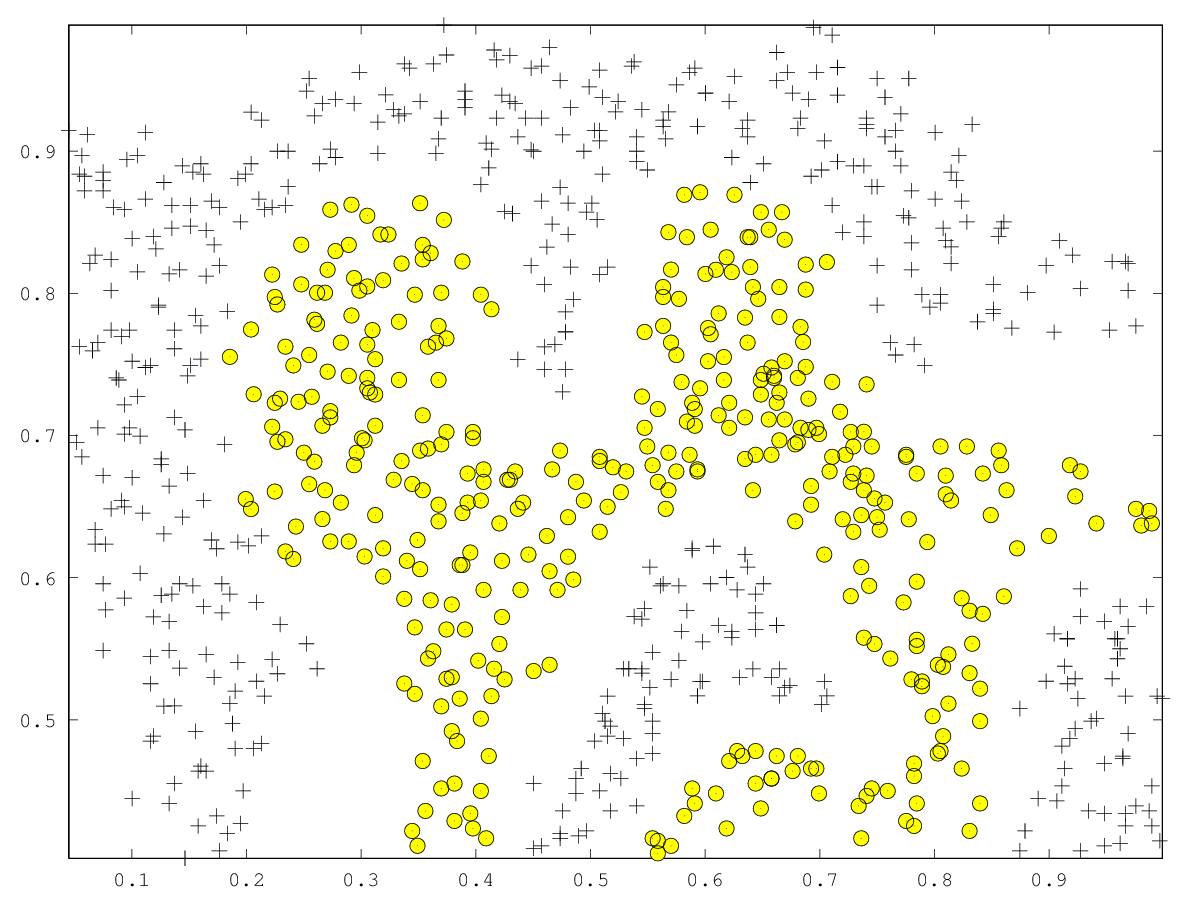

In [14]:
fprintf('\nTraining SVM with RBF Kernel (this may take 1 to 2 minutes) ...\n');

% Load from ex6data2: 
% You will have X, y in your environment
load('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 7/Assignment/ex6/ex6data2.mat');

% SVM Parameters
C = 1; sigma = 0.1;

% We set the tolerance and max_passes lower here so that the code will run
% faster. However, in practice, you will want to run the training to
% convergence.
model= svmTrain(X, y, C, @(x1, x2) gaussianKernel(x1, x2, sigma)); 
visualizeBoundary(X, y, model);

### 1.2.3 Example Dataset 3

In this part of the exercise, you will gain more practical skills on how to use a SVM with a Gaussian kernel. The next part of `ex6.m` will load and display a third dataset (Figure 6). You will be using the SVM with the Gaussian kernel with this dataset.

Loading and Visualizing Data ...


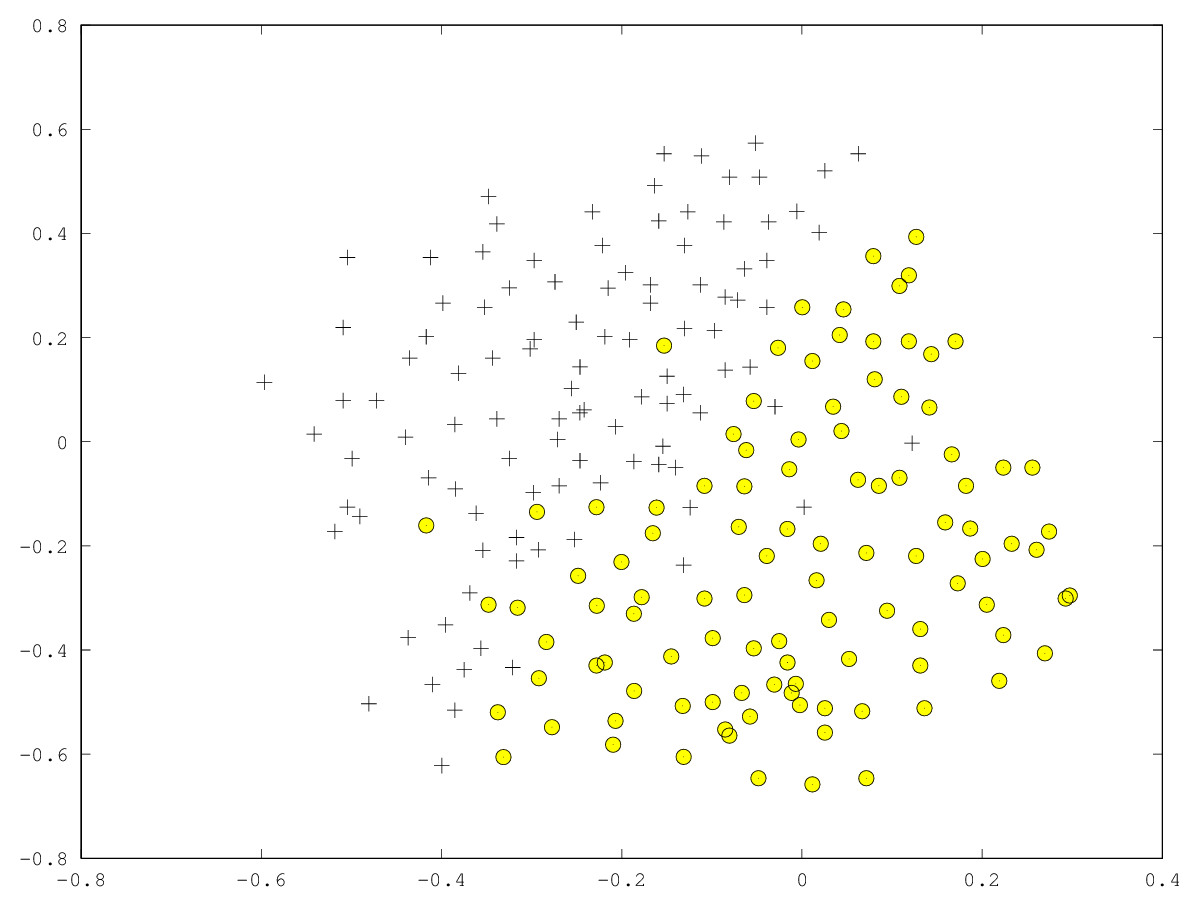

In [15]:
fprintf('Loading and Visualizing Data ...\n')

% Load from ex6data3: 
% You will have X, y in your environment
load('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 7/Assignment/ex6/ex6data3.mat');

% Plot training data
plotData(X, y);

In the provided dataset, `ex6data3.mat`, you are given the variables X, y, Xval, yval. The provided code in `ex6.m` trains the SVM classifier using the training set (X, y) using parameters loaded from `dataset3Params.m`. Your task is to use the cross validation set Xval, yval to determine the best C and $\sigma$ parameter to use. You should write any additional code necessary to help you search over the parameters C and $\sigma$. For both C and $\sigma$, we suggest trying values in multiplicative steps (e.g., 0.01, 0.03, 0.1, 0.3, 1, 3, 10, 30).

Note that you should try all possible pairs of values for C and $\sigma$ (e.g., C=0.3 and $\sigma=0.1$). For example, if you try each of the 8 values listed above for C and for $\sigma^2$ you would end up training and evaluating (on the cross validation set) a total of $8^2 = 64$ different models.

After you have determined the best C and $\sigma$ parameters to use, you should modify the code in `dataset3Params.m`, filling in the best parameters you found. For our best parameters, the SVM returned a decision boundary shown in Figure 7.

**Implementation Tip**: When implementing cross validation to select the best C and $\sigma$ parameter to use, you need to evaluate the error on the cross validation set. Recall that for classification, the error is defined as the fraction of the cross validation examples that were classified incorrectly. In Octave/MATLAB, you can compute this error using $mean(double(predictions ~= yval))$, where predictions is a vector containing all the predictions from the SVM, and yval are the true labels from the cross validation set. You can use the `svmPredict` function to
generate the predictions for the cross validation set.

In [20]:
function [C, sigma] = dataset3Params(X, y, Xval, yval)
    %EX6PARAMS returns your choice of C and sigma for Part 3 of the exercise
    %where you select the optimal (C, sigma) learning parameters to use for SVM
    %with RBF kernel
    %   [C, sigma] = EX6PARAMS(X, y, Xval, yval) returns your choice of C and 
    %   sigma. You should complete this function to return the optimal C and 
    %   sigma based on a cross-validation set.
    %

    % You need to return the following variables correctly.
    C = 1;
    sigma = 0.3;

    % ====================== YOUR CODE HERE ======================
    % Instructions: Fill in this function to return the optimal C and sigma
    %               learning parameters found using the cross validation set.
    %               You can use svmPredict to predict the labels on the cross
    %               validation set. For example, 
    %                   predictions = svmPredict(model, Xval);
    %               will return the predictions on the cross validation set.
    %
    %  Note: You can compute the prediction error using 
    %        mean(double(predictions ~= yval))
    %    values = [0.01 0.03 0.1 0.3 1 3 10 30];
    min_error = inf;

    fprintf('Searching for the best [C, sigma] values\n');

    for C = values
        for sigma = values
            fprintf('Testing C = %f and sigma = %f', C, sigma);
            model = svmTrain(X, y, C, @(x1, x2) gaussianKernel(x1, x2, sigma));
            actual_error = mean(double(svmPredict(model, Xval) ~= yval));
            if (actual_error <= min_error)
                C_best = C;
                sigma_best = sigma;
                min_error = actual_error;
                fprintf('New best [C, sigma] = [%f %f]\n', C_best, sigma_best);
            end
        end
    end
    C = C_best;
    sigma = sigma_best;
    fprintf('Best [C, sigma] = [%f %f] with prediction error = %f\n', C, sigma, min_error);


end

Searching for the best [C, sigma] values
Testing C = 0.010000 and sigma = 0.010000
Training .................................. Done! 

New best [C, sigma] = [0.010000 0.010000]
Testing C = 0.010000 and sigma = 0.030000
Training ....................................... Done! 

New best [C, sigma] = [0.010000 0.030000]
Testing C = 0.010000 and sigma = 0.100000
Training ........................................... Done! 

New best [C, sigma] = [0.010000 0.100000]
Testing C = 0.010000 and sigma = 0.300000
Training ................................................ Done! 

Testing C = 0.010000 and sigma = 1.000000
Training ..................................... Done! 

Testing C = 0.010000 and sigma = 3.000000
Training ................................ Done! 

Testing C = 0.010000 and sigma = 10.000000
Training ........................ Done! 

Testing C = 0.010000 and sigma = 30.000000
Training .................................... Done! 

Testing C = 0.030000 and sigma = 0.010000
Training .......

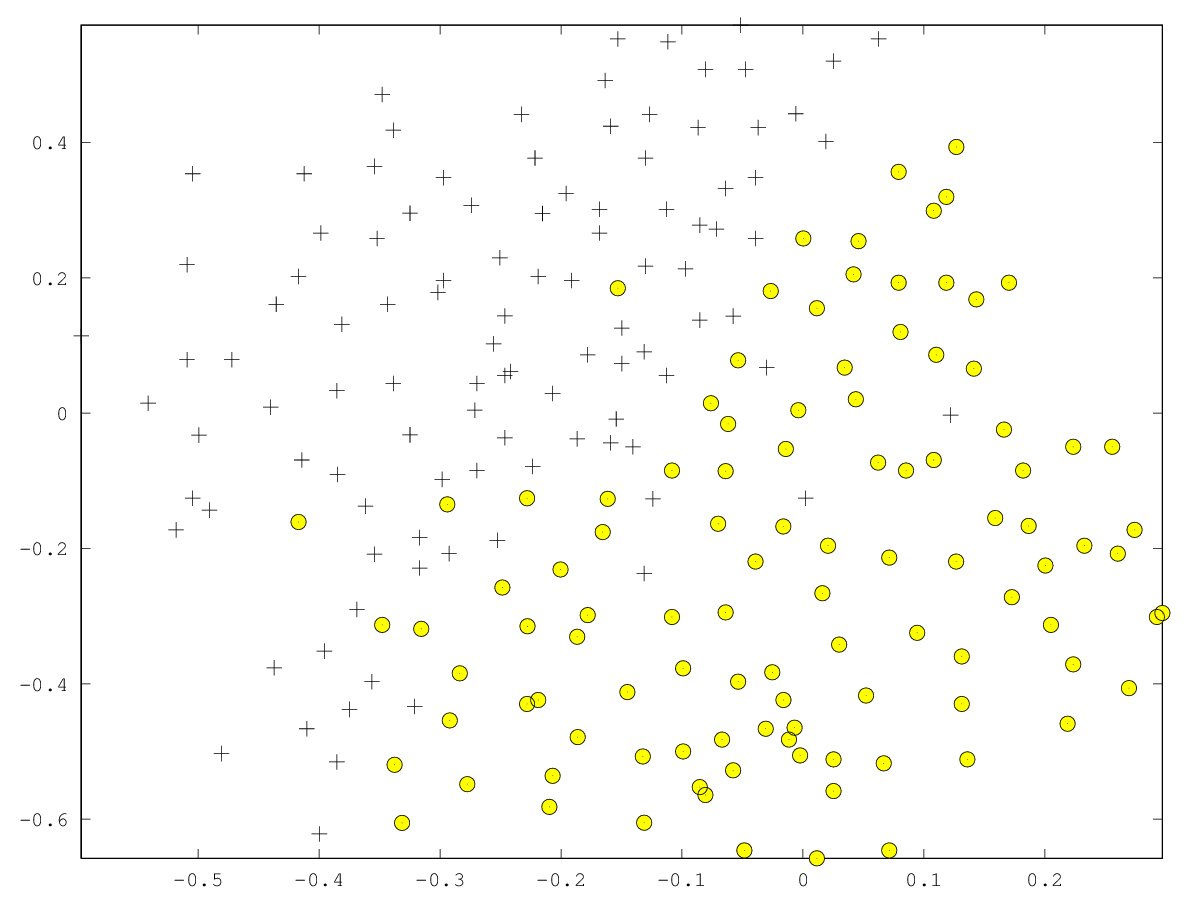

In [22]:
load('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 7/Assignment/ex6/ex6data3.mat');

% Try different SVM Parameters here
[C, sigma] = dataset3Params(X, y, Xval, yval);

% Train the SVM
model= svmTrain(X, y, C, @(x1, x2) gaussianKernel(x1, x2, sigma));
visualizeBoundary(X, y, model);

# 2 Spam Classification

Many email services today provide spam filters that are able to classify emails into spam and non-spam email with high accuracy. In this part of the exercise, you will use SVMs to build your own spam filter.

You will be training a classifier to classify whether a given email, x, is spam (y = 1) or non-spam (y = 0). In particular, you need to convert each email into a feature vector $x \in \mathbb{R}^n$. The following parts of the exercise will walk you through how such a feature vector can be constructed from an email.

Throughout the rest of this exercise, you will be using the the script `ex6_spam.m`. The dataset included for this exercise is based on a a subset of the SpamAssassin Public Corpus. For the purpose of this exercise, you will
only be using the body of the email (excluding the email headers).

## 2.1 Preprocessing Emails

> Anyone knows how much it costs to host a web portal ?
> Well, it depends on how many visitors youre expecting. This can be
> anywhere from less than 10 bucks a month to a couple of $100. You
> should checkout http://www.rackspace.com/ or perhaps Amazon EC2 if
> youre running something big..
> To unsubscribe yourself from this mailing list, send an email to:
> groupname-unsubscribe@egroups.com

Before starting on a machine learning task, it is usually insightful to take a look at examples from the dataset. Figure 8 shows a sample email that contains a URL, an email address (at the end), numbers, and dollar amounts. While many emails would contain similar types of entities (e.g., numbers, other URLs, or other email addresses), the specific entities (e.g., the specific URL or specific dollar amount) will be different in almost every email. Therefore, one method often employed in processing emails is to "normalize" these values, so that all URLs are treated the same, all numbers are treated the same, etc. For example, we could replace each URL in the email with the unique string "httpaddr" to indicate that a URL was present This has the effect of letting the spam classifier make a classification decision based on whether any URL was present, rather than whether a specific URL was present. This typically improves the performance of a spam classifier, since spammers often randomize the URLs, and thus the odds of seeing any particular URL again in a new piece of spam is very small.

In `processEmail.m`, we have implemented the following email preprocessing and normalization steps:

- **Lower-casing**: The entire email is converted into lower case, so that captialization is ignored (e.g., IndIcaTE is treated the same as Indicate).
- **Stripping HTML**: All HTML tags are removed from the emails. Many emails often come with HTML formatting; we remove all the HTML tags, so that only the content remains.
- **Normalizing URLs**: All URLs are replaced with the text "httpaddr".
- **Normalizing Email Addresses**: All email addresses are replaced with the text "emailaddr".
- **Normalizing Numbers**: All numbers are replaced with the text "number".
- **Normalizing Dollars**: All dollar signs (\$) are replaced with the text "dollar".
- **Word Stemming**: Words are reduced to their stemmed form. For example, "discount", "discounts", "discounted" and "discounting" are all replaced with "discount". Sometimes, the Stemmer actually strips off additional characters from the end, so "include", "includes", "included", and "including" are all replaced with "includ".
- **Removal of non-words**: Non-words and punctuation have been removed. All white spaces (tabs, newlines, spaces) have all been trimmed to a single space character.

The result of these preprocessing steps is shown in Figure 9. While pre-processing has left word fragments and non-words, this form turns out to be much easier to work with for performing feature extraction.

### 2.1.1 Vocabulary List

After preprocessing the emails, we have a list of words (e.g., Figure 9) for each email. The next step is to choose which words we would like to use in our classifier and which we would want to leave out.

For this exercise, we have chosen only the most frequently occuring words as our set of words considered (the vocabulary list). Since words that occur rarely in the training set are only in a few emails, they might cause the model to overfit our training set. The complete vocabulary list is in the file `vocab.txt` and also shown in Figure 10. Our vocabulary list was selected by choosing all words which occur at least a 100 times in the spam corpus, resulting in a list of 1899 words. In practice, a vocabulary list with about 10,000 to 50,000 words is often used.

Given the vocabulary list, we can now map each word in the preprocessed emails (e.g., Figure 9) into a list of word indices that contains the index of the word in the vocabulary list. Figure 11 shows the mapping for the sample email. Specifically, in the sample email, the word "anyone" was first normalized to "anyon" and then mapped onto the index 86 in the vocabulary list.

Your task now is to complete the code in `processEmail.m` to perform this mapping. In the code, you are given a string str which is a single word from the processed email. You should look up the word in the vocabulary list `vocabList` and find if the word exists in the vocabulary list. If the word exists, you should add the index of the word into the word indices variable. If the word does not exist, and is therefore not in the vocabulary, you can
skip the word.

Once you have implemented `processEmail.m`, the script `ex6_spam.m` will run your code on the email sample and you should see an output similar to Figures 9 and 11.

**Octave/MATLAB Tip**: In Octave/MATLAB, you can compare two strings with the `strcmp` function. For example, `strcmp(str1, str2)` will return 1 only when both strings are equal. In the provided starter code, vocabList is a "cell-array" containing the words in the vocabulary. In Octave/MATLAB, a cell-array is just like a normal array (i.e., a vector), except that its elements can also be strings (which they can't in a normal Octave/MATLAB matrix/vector), and you index into them using curly braces instead of square brackets. Specifically, to get the word at index i, you can use `vocabList{i}`. You can also use `length(vocabList)` to get the number of words in the vocabulary.

In [ ]:
function vocabList = getVocabList()
    %GETVOCABLIST reads the fixed vocabulary list in vocab.txt and returns a
    %cell array of the words
    %   vocabList = GETVOCABLIST() reads the fixed vocabulary list in vocab.txt 
    %   and returns a cell array of the words in vocabList.


    %% Read the fixed vocabulary list
    fid = fopen('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 7/Assignment/ex6/vocab.txt');

    % Store all dictionary words in cell array vocab{}
    n = 1899;  % Total number of words in the dictionary

    % For ease of implementation, we use a struct to map the strings => integers
    % In practice, you'll want to use some form of hashmap
    vocabList = cell(n, 1);
    for i = 1:n
        % Word Index (can ignore since it will be = i)
        fscanf(fid, '%d', 1);
        % Actual Word
        vocabList{i} = fscanf(fid, '%s', 1);
    end
    fclose(fid);
end


function stem = porterStemmer(inString)
    % Applies the Porter Stemming algorithm as presented in the following
    % paper:
    % Porter, 1980, An algorithm for suffix stripping, Program, Vol. 14,
    %   no. 3, pp 130-137

    % Original code modeled after the C version provided at:
    % http://www.tartarus.org/~martin/PorterStemmer/c.txt

    % The main part of the stemming algorithm starts here. b is an array of
    % characters, holding the word to be stemmed. The letters are in b[k0],
    % b[k0+1] ending at b[k]. In fact k0 = 1 in this demo program (since
    % matlab begins indexing by 1 instead of 0). k is readjusted downwards as
    % the stemming progresses. Zero termination is not in fact used in the
    % algorithm.

    % To call this function, use the string to be stemmed as the input
    % argument.  This function returns the stemmed word as a string.

    % Lower-case string
    inString = lower(inString);

    global j;
    b = inString;
    k = length(b);
    k0 = 1;
    j = k;



    % With this if statement, strings of length 1 or 2 don't go through the
    % stemming process. Remove this conditional to match the published
    % algorithm.
    stem = b;
    if k > 2
        % Output displays per step are commented out.
        %disp(sprintf('Word to stem: %s', b));
        x = step1ab(b, k, k0);
        %disp(sprintf('Steps 1A and B yield: %s', x{1}));
        x = step1c(x{1}, x{2}, k0);
        %disp(sprintf('Step 1C yields: %s', x{1}));
        x = step2(x{1}, x{2}, k0);
        %disp(sprintf('Step 2 yields: %s', x{1}));
        x = step3(x{1}, x{2}, k0);
        %disp(sprintf('Step 3 yields: %s', x{1}));
        x = step4(x{1}, x{2}, k0);
        %disp(sprintf('Step 4 yields: %s', x{1}));
        x = step5(x{1}, x{2}, k0);
        %disp(sprintf('Step 5 yields: %s', x{1}));
        stem = x{1};
    end

    % cons(j) is TRUE <=> b[j] is a consonant.
    function c = cons(i, b, k0)
    c = true;
    switch(b(i))
        case {'a', 'e', 'i', 'o', 'u'}
            c = false;
        case 'y'
            if i == k0
                c = true;
            else
                c = ~cons(i - 1, b, k0);
            end
    end

    % mseq() measures the number of consonant sequences between k0 and j.  If
    % c is a consonant sequence and v a vowel sequence, and <..> indicates
    % arbitrary presence,

    %      <c><v>       gives 0
    %      <c>vc<v>     gives 1
    %      <c>vcvc<v>   gives 2
    %      <c>vcvcvc<v> gives 3
    %      ....
    function n = measure(b, k0)
    global j;
    n = 0;
    i = k0;
    while true
        if i > j
            return
        end
        if ~cons(i, b, k0)
            break;
        end
        i = i + 1;
    end
    i = i + 1;
    while true
        while true
            if i > j
                return
            end
            if cons(i, b, k0)
                break;
            end
            i = i + 1;
        end
        i = i + 1;
        n = n + 1;
        while true
            if i > j
                return
            end
            if ~cons(i, b, k0)
                break;
            end
            i = i + 1;
        end
        i = i + 1;
    end


    % vowelinstem() is TRUE <=> k0,...j contains a vowel
    function vis = vowelinstem(b, k0)
    global j;
    for i = k0:j,
        if ~cons(i, b, k0)
            vis = true;
            return
        end
    end
    vis = false;

    %doublec(i) is TRUE <=> i,(i-1) contain a double consonant.
    function dc = doublec(i, b, k0)
    if i < k0+1
        dc = false;
        return
    end
    if b(i) ~= b(i-1)
        dc = false;
        return
    end
    dc = cons(i, b, k0);


    % cvc(j) is TRUE <=> j-2,j-1,j has the form consonant - vowel - consonant
    % and also if the second c is not w,x or y. this is used when trying to
    % restore an e at the end of a short word. e.g.
    %
    %      cav(e), lov(e), hop(e), crim(e), but
    %      snow, box, tray.

    function c1 = cvc(i, b, k0)
    if ((i < (k0+2)) || ~cons(i, b, k0) || cons(i-1, b, k0) || ~cons(i-2, b, k0))
        c1 = false;
    else
        if (b(i) == 'w' || b(i) == 'x' || b(i) == 'y')
            c1 = false;
            return
        end
        c1 = true;
    end

    % ends(s) is TRUE <=> k0,...k ends with the string s.
    function s = ends(str, b, k)
    global j;
    if (str(length(str)) ~= b(k))
        s = false;
        return
    end % tiny speed-up
    if (length(str) > k)
        s = false;
        return
    end
    if strcmp(b(k-length(str)+1:k), str)
        s = true;
        j = k - length(str);
        return
    else
        s = false;
    end

    % setto(s) sets (j+1),...k to the characters in the string s, readjusting
    % k accordingly.

    function so = setto(s, b, k)
    global j;
    for i = j+1:(j+length(s))
        b(i) = s(i-j);
    end
    if k > j+length(s)
        b((j+length(s)+1):k) = '';
    end
    k = length(b);
    so = {b, k};

    % rs(s) is used further down.
    % [Note: possible null/value for r if rs is called]
    function r = rs(str, b, k, k0)
    r = {b, k};
    if measure(b, k0) > 0
        r = setto(str, b, k);
    end

    % step1ab() gets rid of plurals and -ed or -ing. e.g.

    %       caresses  ->  caress
    %       ponies    ->  poni
    %       ties      ->  ti
    %       caress    ->  caress
    %       cats      ->  cat

    %       feed      ->  feed
    %       agreed    ->  agree
    %       disabled  ->  disable

    %       matting   ->  mat
    %       mating    ->  mate
    %       meeting   ->  meet
    %       milling   ->  mill
    %       messing   ->  mess

    %       meetings  ->  meet

    function s1ab = step1ab(b, k, k0)
    global j;
    if b(k) == 's'
        if ends('sses', b, k)
            k = k-2;
        elseif ends('ies', b, k)
            retVal = setto('i', b, k);
            b = retVal{1};
            k = retVal{2};
        elseif (b(k-1) ~= 's')
            k = k-1;
        end
    end
    if ends('eed', b, k)
        if measure(b, k0) > 0;
            k = k-1;
        end
    elseif (ends('ed', b, k) || ends('ing', b, k)) && vowelinstem(b, k0)
        k = j;
        retVal = {b, k};
        if ends('at', b, k)
            retVal = setto('ate', b(k0:k), k);
        elseif ends('bl', b, k)
            retVal = setto('ble', b(k0:k), k);
        elseif ends('iz', b, k)
            retVal = setto('ize', b(k0:k), k);
        elseif doublec(k, b, k0)
            retVal = {b, k-1};
            if b(retVal{2}) == 'l' || b(retVal{2}) == 's' || ...
                    b(retVal{2}) == 'z'
                retVal = {retVal{1}, retVal{2}+1};
            end
        elseif measure(b, k0) == 1 && cvc(k, b, k0)
            retVal = setto('e', b(k0:k), k);
        end
        k = retVal{2};
        b = retVal{1}(k0:k);
    end
    j = k;
    s1ab = {b(k0:k), k};

    %  step1c() turns terminal y to i when there is another vowel in the stem.
    function s1c = step1c(b, k, k0)
    global j;
    if ends('y', b, k) && vowelinstem(b, k0)
        b(k) = 'i';
    end
    j = k;
    s1c = {b, k};

    % step2() maps double suffices to single ones. so -ization ( = -ize plus
    % -ation) maps to -ize etc. note that the string before the suffix must give
    % m() > 0.
    function s2 = step2(b, k, k0)
    global j;
    s2 = {b, k};
    switch b(k-1)
        case {'a'}
            if ends('ational', b, k) s2 = rs('ate', b, k, k0);
            elseif ends('tional', b, k) s2 = rs('tion', b, k, k0); end;
        case {'c'}
            if ends('enci', b, k) s2 = rs('ence', b, k, k0);
            elseif ends('anci', b, k) s2 = rs('ance', b, k, k0); end;
        case {'e'}
            if ends('izer', b, k) s2 = rs('ize', b, k, k0); end;
        case {'l'}
            if ends('bli', b, k) s2 = rs('ble', b, k, k0);
            elseif ends('alli', b, k) s2 = rs('al', b, k, k0);
            elseif ends('entli', b, k) s2 = rs('ent', b, k, k0);
            elseif ends('eli', b, k) s2 = rs('e', b, k, k0);
            elseif ends('ousli', b, k) s2 = rs('ous', b, k, k0); end;
        case {'o'}
            if ends('ization', b, k) s2 = rs('ize', b, k, k0);
            elseif ends('ation', b, k) s2 = rs('ate', b, k, k0);
            elseif ends('ator', b, k) s2 = rs('ate', b, k, k0); end;
        case {'s'}
            if ends('alism', b, k) s2 = rs('al', b, k, k0);
            elseif ends('iveness', b, k) s2 = rs('ive', b, k, k0);
            elseif ends('fulness', b, k) s2 = rs('ful', b, k, k0);
            elseif ends('ousness', b, k) s2 = rs('ous', b, k, k0); end;
        case {'t'}
            if ends('aliti', b, k) s2 = rs('al', b, k, k0);
            elseif ends('iviti', b, k) s2 = rs('ive', b, k, k0);
            elseif ends('biliti', b, k) s2 = rs('ble', b, k, k0); end;
        case {'g'}
            if ends('logi', b, k) s2 = rs('log', b, k, k0); end;
    end
    j = s2{2};

    % step3() deals with -ic-, -full, -ness etc. similar strategy to step2.
    function s3 = step3(b, k, k0)
    global j;
    s3 = {b, k};
    switch b(k)
        case {'e'}
            if ends('icate', b, k) s3 = rs('ic', b, k, k0);
            elseif ends('ative', b, k) s3 = rs('', b, k, k0);
            elseif ends('alize', b, k) s3 = rs('al', b, k, k0); end;
        case {'i'}
            if ends('iciti', b, k) s3 = rs('ic', b, k, k0); end;
        case {'l'}
            if ends('ical', b, k) s3 = rs('ic', b, k, k0);
            elseif ends('ful', b, k) s3 = rs('', b, k, k0); end;
        case {'s'}
            if ends('ness', b, k) s3 = rs('', b, k, k0); end;
    end
    j = s3{2};

    % step4() takes off -ant, -ence etc., in context <c>vcvc<v>.
    function s4 = step4(b, k, k0)
    global j;
    switch b(k-1)
        case {'a'}
            if ends('al', b, k) end;
        case {'c'}
            if ends('ance', b, k)
            elseif ends('ence', b, k) end;
        case {'e'}
            if ends('er', b, k) end;
        case {'i'}
            if ends('ic', b, k) end;
        case {'l'}
            if ends('able', b, k)
            elseif ends('ible', b, k) end;
        case {'n'}
            if ends('ant', b, k)
            elseif ends('ement', b, k)
            elseif ends('ment', b, k)
            elseif ends('ent', b, k) end;
        case {'o'}
            if ends('ion', b, k)
                if j == 0
                elseif ~(strcmp(b(j),'s') || strcmp(b(j),'t'))
                    j = k;
                end
            elseif ends('ou', b, k) end;
        case {'s'}
            if ends('ism', b, k) end;
        case {'t'}
            if ends('ate', b, k)
            elseif ends('iti', b, k) end;
        case {'u'}
            if ends('ous', b, k) end;
        case {'v'}
            if ends('ive', b, k) end;
        case {'z'}
            if ends('ize', b, k) end;
    end
    if measure(b, k0) > 1
        s4 = {b(k0:j), j};
    else
        s4 = {b(k0:k), k};
    end

    % step5() removes a final -e if m() > 1, and changes -ll to -l if m() > 1.
    function s5 = step5(b, k, k0)
    global j;
    j = k;
    if b(k) == 'e'
        a = measure(b, k0);
        if (a > 1) || ((a == 1) && ~cvc(k-1, b, k0))
            k = k-1;
        end
    end
    if (b(k) == 'l') && doublec(k, b, k0) && (measure(b, k0) > 1)
        k = k-1;
    end
    s5 = {b(k0:k), k};

function word_indices = processEmail(email_contents)
    %PROCESSEMAIL preprocesses a the body of an email and
    %returns a list of word_indices 
    %   word_indices = PROCESSEMAIL(email_contents) preprocesses 
    %   the body of an email and returns a list of indices of the 
    %   words contained in the email. 
    %

    % Load Vocabulary
    vocabList = getVocabList();

    % Init return value
    word_indices = [];

    % ========================== Preprocess Email ===========================

    % Find the Headers ( \n\n and remove )
    % Uncomment the following lines if you are working with raw emails with the
    % full headers

    % hdrstart = strfind(email_contents, ([char(10) char(10)]));
    % email_contents = email_contents(hdrstart(1):end);

    % Lower case
    email_contents = lower(email_contents);

    % Strip all HTML
    % Looks for any expression that starts with < and ends with > and replace
    % and does not have any < or > in the tag it with a space
    email_contents = regexprep(email_contents, '<[^<>]+>', ' ');

    % Handle Numbers
    % Look for one or more characters between 0-9
    email_contents = regexprep(email_contents, '[0-9]+', 'number');

    % Handle URLS
    % Look for strings starting with http:// or https://
    email_contents = regexprep(email_contents, ...
                               '(http|https)://[^\s]*', 'httpaddr');

    % Handle Email Addresses
    % Look for strings with @ in the middle
    email_contents = regexprep(email_contents, '[^\s]+@[^\s]+', 'emailaddr');

    % Handle $ sign
    email_contents = regexprep(email_contents, '[$]+', 'dollar');


    % ========================== Tokenize Email ===========================

    % Output the email to screen as well
    fprintf('\n==== Processed Email ====\n\n');

    % Process file
    l = 0;

    while ~isempty(email_contents)

        % Tokenize and also get rid of any punctuation
        [str, email_contents] = ...
           strtok(email_contents, ...
                  [' @$/#.-:&*+=[]?!(){},''">_<;%' char(10) char(13)]);

        % Remove any non alphanumeric characters
        str = regexprep(str, '[^a-zA-Z0-9]', '');

        % Stem the word 
        % (the porterStemmer sometimes has issues, so we use a try catch block)
        try str = porterStemmer(strtrim(str)); 
        catch str = ''; continue;
        end;

        % Skip the word if it is too short
        if length(str) < 1
           continue;
        end

        % Look up the word in the dictionary and add to word_indices if
        % found
        % ====================== YOUR CODE HERE ======================
        % Instructions: Fill in this function to add the index of str to
        %               word_indices if it is in the vocabulary. At this point
        %               of the code, you have a stemmed word from the email in
        %               the variable str. You should look up str in the
        %               vocabulary list (vocabList). If a match exists, you
        %               should add the index of the word to the word_indices
        %               vector. Concretely, if str = 'action', then you should
        %               look up the vocabulary list to find where in vocabList
        %               'action' appears. For example, if vocabList{18} =
        %               'action', then, you should add 18 to the word_indices 
        %               vector (e.g., word_indices = [word_indices ; 18]; ).
        % 
        % Note: vocabList{idx} returns a the word with index idx in the
        %       vocabulary list.
        % 
        % Note: You can use strcmp(str1, str2) to compare two strings (str1 and
        %       str2). It will return 1 only if the two strings are equivalent.
        %

        for i = 1:length(vocabList)
            if(strcmp(str, vocabList{i}))
                word_indices = [ word_indices ; i];
            end
        end

        % =============================================================


        % Print to screen, ensuring that the output lines are not too long
        if (l + length(str) + 1) > 78
            fprintf('\n');
            l = 0;
        end
        fprintf('%s ', str);
        l = l + length(str) + 1;

    end

    % Print footer
    fprintf('\n\n=========================\n');

end

function file_contents = readFile(filename)
    %READFILE reads a file and returns its entire contents 
    %   file_contents = READFILE(filename) reads a file and returns its entire
    %   contents in file_contents
    %

    % Load File
    fid = fopen(filename);
    if fid
        file_contents = fscanf(fid, '%c', inf);
        fclose(fid);
    else
        file_contents = '';
        fprintf('Unable to open %s\n', filename);
    end

end


%% Initialization
clear ; close all; clc

fprintf('\nPreprocessing sample email (emailSample1.txt)\n');

% Extract Features
file_contents = readFile('/home/roger/Workspace/MOOC/Coursera/MLearning/Week 7/Assignment/ex6/emailSample1.txt');
word_indices  = processEmail(file_contents);

% Print Stats
fprintf('Word Indices: \n');
fprintf(' %d', word_indices);
fprintf('\n\n');


## 2.2 Extracting Features from Emails

You will now implement the feature extraction that converts each email into a vector in $\mathbb{R}^n$. For this exercise, you will be using n = # words in vocabulary list. Specifically, the feature $x_i \in {0, 1}$ for an email corresponds to whether the i-th word in the dictionary occurs in the email. That is, $x_i = 1$ if the i-th word is in the email and $x_i = 0$ if the i-th word is not present in the email. Thus, for a typical email, this feature would look like:

$$x = \begin{bmatrix}
0 \\
\vdots \\
1 \\
0 \\
\vdots \\
1 \\
0 \\
\vdots \\
0
\end{bmatrix} \in \mathbb{R}^n$$

You should now complete the code in `emailFeatures.m` to generate a feature vector for an email, given the word indices. Once you have implemented `emailFeatures.m`, the next part of `ex6_spam.m` will run your code on the email sample. You should see that the feature vector had length 1899 and 45 non-zero entries.

## 2.3 Training SVM for Spam Classification

After you have completed the feature extraction functions, the next step of `ex6_spam.m` will load a preprocessed training dataset that will be used to train a SVM classifier. `spamTrain.mat` contains 4000 training examples of spam and non-spam email, while `spamTest.mat` contains 1000 test examples. Each original email was processed using the `processEmail` and `emailFeatures` functions and converted into a vector $x^{(i)} \in \mathbb{R}^{1899}.

After loading the dataset, `ex6_spam.m` will proceed to train a SVM to classify between spam (y = 1) and non-spam (y = 0) emails. Once the training completes, you should see that the classifier gets a training accuracy of about 99.8\% and a test accuracy of about 98.5\%.

In [ ]:
%% =========== Part 3: Train Linear SVM for Spam Classification ========
%  In this section, you will train a linear classifier to determine if an
%  email is Spam or Not-Spam.

% Load the Spam Email dataset
% You will have X, y in your environment
load('spamTrain.mat');

fprintf('\nTraining Linear SVM (Spam Classification)\n')
fprintf('(this may take 1 to 2 minutes) ...\n')

C = 0.1;
model = svmTrain(X, y, C, @linearKernel);

p = svmPredict(model, X);

fprintf('Training Accuracy: %f\n', mean(double(p == y)) * 100);

%% =================== Part 4: Test Spam Classification ================
%  After training the classifier, we can evaluate it on a test set. We have
%  included a test set in spamTest.mat

% Load the test dataset
% You will have Xtest, ytest in your environment
load('spamTest.mat');

fprintf('\nEvaluating the trained Linear SVM on a test set ...\n')

p = svmPredict(model, Xtest);

fprintf('Test Accuracy: %f\n', mean(double(p == ytest)) * 100);
pause;


%% ================= Part 5: Top Predictors of Spam ====================
%  Since the model we are training is a linear SVM, we can inspect the
%  weights learned by the model to understand better how it is determining
%  whether an email is spam or not. The following code finds the words with
%  the highest weights in the classifier. Informally, the classifier
%  'thinks' that these words are the most likely indicators of spam.
%

% Sort the weights and obtin the vocabulary list
[weight, idx] = sort(model.w, 'descend');
vocabList = getVocabList();

fprintf('\nTop predictors of spam: \n');
for i = 1:15
    fprintf(' %-15s (%f) \n', vocabList{idx(i)}, weight(i));
end

fprintf('\n\n');
fprintf('\nProgram paused. Press enter to continue.\n');
pause;

%% =================== Part 6: Try Your Own Emails =====================
%  Now that you've trained the spam classifier, you can use it on your own
%  emails! In the starter code, we have included spamSample1.txt,
%  spamSample2.txt, emailSample1.txt and emailSample2.txt as examples. 
%  The following code reads in one of these emails and then uses your 
%  learned SVM classifier to determine whether the email is Spam or 
%  Not Spam

% Set the file to be read in (change this to spamSample2.txt,
% emailSample1.txt or emailSample2.txt to see different predictions on
% different emails types). Try your own emails as well!
filename = 'spamSample1.txt';

% Read and predict
file_contents = readFile(filename);
word_indices  = processEmail(file_contents);
x             = emailFeatures(word_indices);
p = svmPredict(model, x);

fprintf('\nProcessed %s\n\nSpam Classification: %d\n', filename, p);
fprintf('(1 indicates spam, 0 indicates not spam)\n\n');
